# Helmholtz 1D: Building The Multilevel Hierarchy, Step-by-Step
* Discretization: 5-point (4th order).
* Fixed-domain problem; non-repetitive, so we generate TVs over entire domain.
* Fix aggregate size to $4$ points. Consider a certain aggregate in the domain (say, the first one).
* Observe beahviour vs. $\nu$:
  * Create relaxed TVs with $\nu$ Kaczmarz relaxation sweeps.
  * Create the coarsening operator $R$ using SVD. Observe singular value decay rate.
  * Observe two-level mini-cycle convergence factor before slowing down.

## Shrinkage Factor
Given an iterative method, we can calculate whether it's a good smoothing candidate, even before measuring its smoothing rate in conjunction with a coarsening operator $R$ via the mock cycle.

### Definition 1 (Old)
* Start from $5$ different random starts $x_0 = rand[-1,1]$, for each  apply the method for $A x = 0$ to obtain iterates $x_1, x_2, \dots$.
* For each iterate, calculate the Residual to Error Ratio (RER) $r_i := \|A x_i\|_2 / \|x_i\|_2$ and the RER reduction factor per sweep, $c_i := r_i / r_{i-1}$, $i = 1, 2, \dots$.
* Average $c_i$ over the $5$ starts.
* Terminate the method after $n_{max}$ sweeps are reached, or $\mu_i > \mu_{max}$ (we use $n_{max} = 20, \mu_{max} = 1.1$).
* Fit a piecewise constant/power-law-with-intercept model in least-squares sesnse:
$$ c(n) = \mu_0, \qquad n \leq n_0\,, $$
$$ c(n) = \mu_{\infty} - (\mu_{\infty} - \mu_0) (\frac{n}{n_0})^p, \qquad n \geq n_0\,. $$
* The model depends on the parameters $\mu_0, n_0, \mu_{\infty}, p$. The **smoothing factor** is defined as $\mu_0$, the initial constant RER reduction, which is sustained for $n_0$ sweeps. Then the convegence is overtaken by smooth components; the asymptotic convergence factor estimate is $\mu_{\infty}$, and the power-law rate of reaching it is $p$ (which is negative).

### Definition 2 (Now in Use): Point of Diminishing Returns
* Start from $5$ different random starts $x_0 = rand[-1,1]$, for each  apply the method for $A x = 0$ to obtain iterates $x_1, x_2, \dots$.
* For each iterate, calculate the Residual to Error Ratio (RER) $r_i := \|A x_i\|_2 / \|x_i\|_2$ and the total RER reduction factor per sweep, $c_i := r_i / r_0$, $i = 1, 2, \dots$.
* Average $c_i$ over the $5$ starts.
* Terminate the method after $n_{max}$ sweeps are reached, or $\mu_i > \mu_{max}$ (we use $n_{max} = 20, \mu_{max} = 1.1$).
* Calculate the RER reduction per unit sweep, $e_i := c_i^{1/i}$. Let $i$ be $min(argmin_i e_i + 3, len(e))$.
* Set $\mu \leftarrow e_i$ and output the number of sweeps $i$ as well.

In [22]:
import collections
import logging
import numpy as np
import matplotlib.pyplot as plt
import helmholtz as hm
import pandas as pd
import scipy.sparse
import sklearn.metrics.pairwise
import sys
from numpy.ma.testutils import assert_array_almost_equal
from scipy.linalg import eig, norm, svd
from scipy.sparse.linalg import eigs
from scipy import optimize

%load_ext autoreload
%autoreload 2

np.set_printoptions(linewidth=500, precision=3, suppress=True, threshold=100000)
for handler in logging.root.handlers[:]: logging.root.removeHandler(handler)
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(levelname)-8s %(message)s",
                    datefmt="%a, %d %b %Y %H:%M:%S")

logger = logging.getLogger("main")
_LOGGER = logger

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
def check_coarsening(level, aggregate_size, default_aggregate_size: int = 4):
    """Checks coarsening based on relaxed TVs, for different number of relaxation sweeps.
    If aggregate_size is not None, forces that aggregate size for the entire domain."""
    num_sweeps_values = 5 * 2 ** np.arange(8)

    fig, axs = plt.subplots(len(num_sweeps_values), 3, figsize=(16, 3 * len(num_sweeps_values)))
    for row, num_sweeps in enumerate(num_sweeps_values):
        # Create relaxed TVs.
        x = hm.solve.run.run_iterative_method(
            level.operator, lambda x: level.relax(x, b), x_random, num_sweeps=num_sweeps)[0]

        start, end = 0, aggregate_size if aggregate_size is not None else default_aggregate_size
        x_aggregate_t = x[start:end].transpose()
        r, s = hm.setup.coarsening.create_coarsening(x_aggregate_t, threshold)
        r = r.asarray()

        # Relaxed vectors.
        ax = axs[row, 0]
        for i in range(3):
            ax.plot(x[:, i]);
        ax.grid(True)
        ax.set_title(r"Test Vectors, $\nu={}$ sweeps".format(num_sweeps))

        ax = axs[row, 1]
        # R should be real-valued, but cast just in case.
        for i, ri in enumerate(np.real(r)):
            ax.plot(ri)
        ax.set_title(r"Agg Size {} $n_c$ {}".format(r.shape[1], r.shape[0]))
        ax.set_ylabel(r"$R$ rows")
        ax.grid(True);

        # Singular values, normalized to sigma_max = 1.
        ax = axs[row, 2]
        ax.plot(s / s[0], "rx")
        ax.set_title("Singular Values")
        ax.set_xlabel(r"$k$")
        ax.set_ylabel(r"$\sigma_k$")
        ax.grid(True);

        print("nu", "{:2d}".format(num_sweeps), "s", s / s[0], "Energy error", (1 - np.cumsum(s ** 2) / sum(s ** 2)) ** 0.5)

        # Generate coarse variables (R) on the non-repetitive domain.
        r, aggregates, nc, energy_error = hm.setup.coarsening.create_coarsening_full_domain(x, threshold=threshold,
                                                                                           fixed_aggregate_size=aggregate_size)
        _LOGGER.info("Agg {}".format(np.array([len(aggregate) for aggregate in aggregates])))
        _LOGGER.info("nc  {}".format(nc))
        _LOGGER.info("Energy error mean {:.4f} max {:.4f}".format(np.mean(energy_error), np.max(energy_error)))
        mock_conv_factor = np.array(
            [hm.setup.auto_setup.mock_cycle_conv_factor(level, r, nu) for nu in np.arange(1, 16, dtype=int)])
        _LOGGER.info("Mock cycle conv factor {}".format(np.array2string(mock_conv_factor, precision=3)))

In [24]:
def check_relax_cycle_shrinkage(multilevel):
    """Checks the two-level relaxation cycle shrinkage vs. relaxation."""
    def relax_cycle(x):
        return hm.solve.relax_cycle.relax_cycle(multilevel, 1.0, 2, 2, 4, num_levels=num_levels).run(x)

    fig, ax = plt.subplots(1, 1, figsize=(6, 4))

    num_examples = 5
    b = np.zeros((a.shape[0], num_examples))

    operator = lambda x: a.dot(x)
    relax = lambda x: level.relax(x, b)

    relax_b = lambda x, b: level.relax(x, b)
    relax_cycle_b = lambda x, b: relax_cycle(x)

    for title, method, method_b, work, color in zip(
        ("Kaczmarz", "Mini-cycle"), (relax, relax_cycle), (relax_b, relax_cycle_b), (1, 6), ("blue", "red")):
        #print(title)
        y, conv_factor = hm.solve.run.run_iterative_method(
            level.operator, method, hm.solve.run.random_test_matrix((level.size, ), num_examples=1), 
            30,  print_frequency=None)

        factor, num_sweeps, rer, conv = hm.solve.smoothing.shrinkage_factor(
            operator, method_b, (a.shape[0], ), print_frequency=1, max_sweeps=20, slow_conv_factor=0.99, leeway_sweeps=3)
        hm.solve.smoothing.plot_diminishing_returns_point(factor, num_sweeps, conv, ax, title=title, color=color)
        print("{:<10s} RER at point of diminishing returns {:.2f} num_sweeps {:>2d} work {:>2d} RER-per-sweep {:.2f}".format(
            title, np.mean(rer[num_sweeps]), num_sweeps, work, np.mean(rer[num_sweeps] / rer[0]) ** (1/(num_sweeps * work))))

    ax.legend();
    # y, conv_factor = hm.solve.run.run_iterative_method(
    #     level.operator, relax_cycle, hm.solve.run.random_test_matrix((level.size, ), num_examples=1), 
    #     10,  print_frequency=1)
    # y_all[num_levels] = y
    # print("Conv Factor {:.5f}".format(conv_factor))

In [25]:
# Fixed seed for reproducible results.
np.random.seed(0)

# Domain size.
n = 96
# Scaled wave number.
kh = 0.5

# Number of test vectors.
num_examples = 20
threshold = 0.1

# Boottstrapping parameters.
threshold = 0.1
interpolation_method = "ls"
num_test_examples = 5

## Level 0->1 Coarsening

### Coarsening Quality
We measure the gap between the second and third singular values as a function of the number of TV relaxation sweeps $\nu$. We force the aggregate size to be $4$.

In [26]:
a = hm.linalg.helmholtz_1d_5_point_operator(kh, n).tocsr()
level = hm.setup.hierarchy.create_finest_level(a)
x_random = hm.solve.run.random_test_matrix((a.shape[0],), num_examples=num_examples)
b = np.zeros_like(x_random)

nu  5 s [1.    0.914 0.185 0.071] Energy error [0.683 0.145 0.052 0.   ]
INFO     Agg [4 4 1 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3]
INFO     nc  [3 3 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2]
INFO     Energy error mean 0.0548 max 0.0860
INFO     Mock cycle conv factor [0.322 0.255 0.096 0.079 0.04  0.021 0.014 0.006 0.004 0.004 0.004 0.004 0.004 0.004 0.003]
nu 10 s [1.    0.823 0.18  0.041] Energy error [0.645 0.141 0.031 0.   ]
INFO     Agg [4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
INFO     nc  [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
INFO     Energy error mean 0.0215 max 0.0322
INFO     Mock cycle conv factor [0.314 0.283 0.094 0.08  0.043 0.021 0.018 0.005 0.004 0.003 0.003 0.002 0.002 0.001 0.001]
nu 20 s [1.    0.737 0.154 0.013] Energy error [0.602 0.123 0.011 0.   ]
INFO     Agg [4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
INFO     nc  [3 2 3 3 3 2 2 3 2 2 3 3 3 3 3 3 2 3 3 3 3 2 3 3]
INFO     Energy error mean 0.0341 max 0.0970
INFO     Mock cy

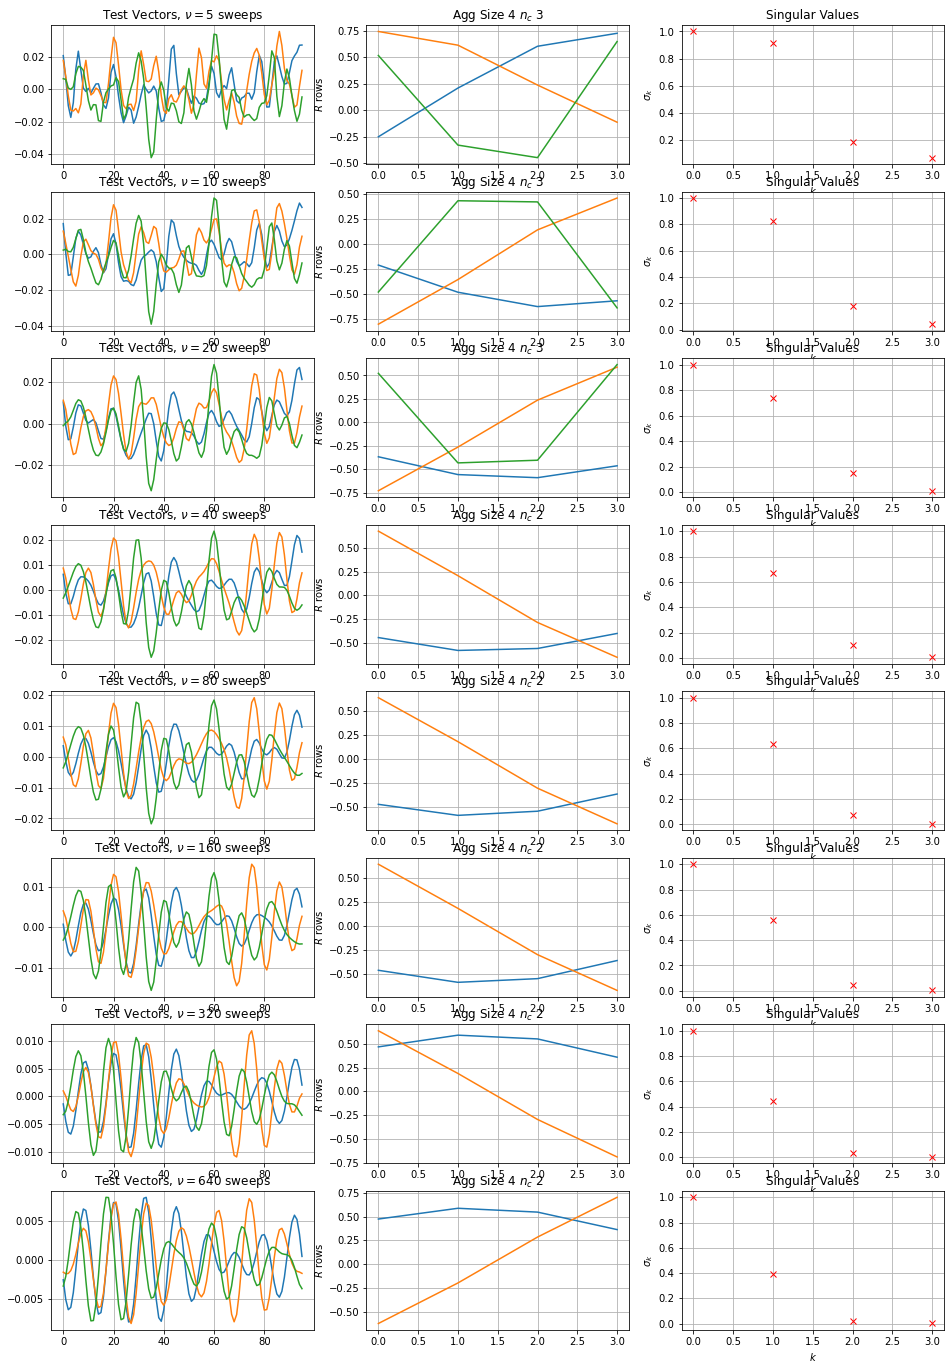

In [27]:
check_coarsening(level, 4)

The gap $\sigma_2 - \sigma_3$ increases with $\nu$, showing that an aggregate size of $4$ is fine (we can obtain an energy error as small as we want given a large enough $\nu$).

### Relaxation Shrinkage Factor

INFO         0 |r| 1.35531125e+00 RER 3.03035
INFO         1 |r| 7.33452322e-01 (0.54274) RER 2.17300 (0.71592) 0.33896
INFO         2 |r| 4.24947422e-01 (0.58067) RER 1.47687 (0.67935) 0.29028
INFO         3 |r| 2.65880367e-01 (0.62654) RER 1.01482 (0.68707) 0.26521
INFO         4 |r| 1.81353522e-01 (0.68346) RER 0.73529 (0.72510) 0.25035
INFO         5 |r| 1.36624580e-01 (0.75330) RER 0.57772 (0.78524) 0.24046
INFO         6 |r| 1.11325081e-01 (0.81505) RER 0.48632 (0.84150) 0.23315
INFO         7 |r| 9.49838496e-02 (0.85380) RER 0.42611 (0.87635) 0.22736
INFO         8 |r| 8.37967016e-02 (0.88269) RER 0.38434 (0.90238) 0.22257
INFO         9 |r| 7.54787776e-02 (0.90100) RER 0.35291 (0.91844) 0.21851
INFO        10 |r| 6.90468463e-02 (0.91486) RER 0.32835 (0.93051) 0.21498
INFO        11 |r| 6.38932107e-02 (0.92531) RER 0.30844 (0.93949) 0.21186
INFO        12 |r| 5.96314606e-02 (0.93318) RER 0.29177 (0.94612) 0.20908
INFO        13 |r| 5.60257123e-02 (0.93936) RER 0.27746 (0.95126) 

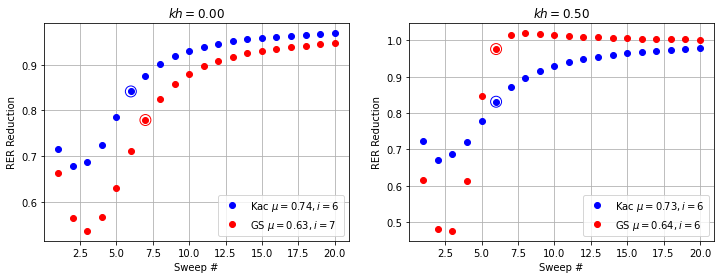

In [28]:
kh_values = [0, 0.5]
fig, axs = plt.subplots(1, len(kh_values), figsize=(12, 4))

kaczmarz = lambda a: hm.solve.relax.KaczmarzRelaxer(a, scipy.sparse.eye(a.shape[0]))
gs = lambda a: hm.solve.relax.GsRelaxer(a)
work = 1

# Kaczmarz.
for kh_value, ax in zip(kh_values, axs):
    a_kh = hm.linalg.helmholtz_1d_5_point_operator(kh_value, n).tocsr()
    operator = lambda x: a_kh.dot(x)

    for title, relax, color in zip(("Kac", "GS"), (kaczmarz, gs), ("blue", "red")):
        method = relax(a_kh)
        factor, num_sweeps, rer, conv = hm.solve.smoothing.shrinkage_factor(
            operator, lambda x, b: method.step(x, b), (a_kh.shape[0], ), print_frequency=1, max_sweeps=20, slow_conv_factor=1.1)
        hm.solve.smoothing.plot_diminishing_returns_point(factor, num_sweeps, conv, ax, title=title, color=color)
        print("{:<10s} RER at point of diminishing returns {:.2f} num_sweeps {:>2d} work {:>2d} RER-per-sweep {:.2f}".format(
            title, np.mean(rer[num_sweeps]), num_sweeps, work, np.mean(rer[num_sweeps] / rer[0]) ** (1/(num_sweeps * work))))
    
    ax.set_title(r"$kh = {:.2f}$".format(kh_value))
    ax.legend()

The point of diminishing returns in each scatterplot is circled.

This estimate seems to give a reasonable estimate for both $kh$ values and both relaxation schemes (albeit not a quantitative smoothing factor, which can only be defined based on a coarsening), showing that GS is a better smoother for both $kh = 0, 0.5$, but slightly diverges for $kh = 0.5$. The RER at the point of diminishing returns is much smaller.

Averaging over multiple random starts helps reduce noise, as well as assuming a constant reduction per sweep in the initial sweeps (as opposed to a linear model, say). We are only interested in a rough estimate.

### Two-level Bootstrapping

In [29]:
max_levels = 2
num_bootstrap_steps = 1
num_sweeps = 10

x_log = []
r_log = []

# Initialize hierarchy to 1-level and fine-level test functions to random.
finest = 0
multilevel = hm.hierarchy.multilevel.Multilevel(level)

_LOGGER.info("Relax at level {} size {}".format(finest, level.size))
b = np.zeros((a.shape[0], num_examples))
_, relax_conv_factor = hm.solve.run.run_iterative_method(
    level.operator, lambda x: level.relax(x, b), 
    hm.solve.run.random_test_matrix((a.shape[0],), num_examples=num_examples), num_sweeps=100)
_LOGGER.info("Relax convergence factor {:.3f}".format(relax_conv_factor))

# TODO(orenlivne): generalize to d-dimensions. This is specific to 1D.
x = hm.solve.run.random_test_matrix((a.shape[0],), num_examples=num_examples)
# Improve vectors with 1-level relaxation.
x_log.append(x)

_LOGGER.info("Generating TVs with {} sweeps".format(num_sweeps))
x, _ = hm.solve.run.run_iterative_method(
    level.operator, lambda x: level.relax(x, b), x, num_sweeps=num_sweeps)
_LOGGER.info("RER {:.3f}".format(norm(a.dot(x)) / norm(x)))
x_log.append(x)

# Bootstrap with an increasingly deeper hierarchy (add one level at a time).
num_levels = 2
_LOGGER.info("bootstrap on grid size {} with {} levels".format(x.shape[0], max_levels))
_LOGGER.info("-" * 80)
for i in range(num_bootstrap_steps):
    _LOGGER.info("Bootstrap step {}/{}".format(i + 1, num_bootstrap_steps))
    # Set relax_conv_factor to a high value so that we never append a bootstrap vector to the TV set.
    x, multilevel = hm.setup.auto_setup.bootstap(
        x, multilevel, num_levels, 2.0,
        num_sweeps=num_sweeps, interpolation_method=interpolation_method, threshold=threshold)
    x_log.append(x)
    r_log.append(multilevel.level[1].r)
    _LOGGER.info("RER {:.6f}".format(norm(a.dot(x)) / norm(x)))
    _LOGGER.info("-" * 80)

INFO     Relax at level 0 size 96
INFO     Relax convergence factor 0.991
INFO     Generating TVs with 10 sweeps
INFO     RER 0.292
INFO     bootstrap on grid size 96 with 2 levels
INFO     --------------------------------------------------------------------------------
INFO     Bootstrap step 1/1
INFO     Relax cycle conv factor 0.995 asymptotic RQ 0.212 RER 0.236 P error -1.000
INFO     Improving vectors by relaxation cycles
INFO     Coarsening level 0->1
WARNING  Could not find a good coarsening ratio for aggregate 95:96, n 1 nc 1 cr 1.00
INFO     Agg [4 4 4 4 4 4 4 4 4 4 4 4 6 4 4 4 4 4 4 4 4 4 4 1 1]
INFO     nc  [2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 1 1]
INFO     Energy error mean 0.0650 max 0.0974
INFO     Mock cycle conv factor [0.586 0.312 0.194 0.147 0.136 0.123 0.087 0.074 0.069 0.065 0.058]
INFO     P max error: fit 0.070 val 0.316 test 0.124; alpha mean 0.004
INFO     fit  set size 15 P L2 error mean 0.01 max 0.02 A error mean 0.04 max 0.07
INFO     test set size 

### Relaxation Cycle Shrinkage
We compare relaxation cycle with $\nu_1=2, \nu_2=2, \nu_{coarse}=4$ with the resulting $P$ and $R$ from the bootstrap step, with Kaczmarz relaxation.

INFO         0 |r| 1.31379521e+00 RER 2.94375
INFO         1 |r| 7.15067169e-01 (0.54464) RER 2.12656 (0.72187) 0.33740
INFO         2 |r| 4.24443095e-01 (0.59393) RER 1.48542 (0.69796) 0.28751
INFO         3 |r| 2.68490998e-01 (0.63293) RER 1.03560 (0.69704) 0.26138
INFO         4 |r| 1.85127609e-01 (0.68967) RER 0.75950 (0.73321) 0.24610
INFO         5 |r| 1.37925204e-01 (0.74498) RER 0.59072 (0.77740) 0.23604
INFO         6 |r| 1.09440307e-01 (0.79329) RER 0.48426 (0.81921) 0.22874
INFO         7 |r| 9.19923820e-02 (0.84043) RER 0.41799 (0.86240) 0.22306
INFO         8 |r| 8.02989416e-02 (0.87280) RER 0.37313 (0.89202) 0.21839
INFO         9 |r| 7.19781409e-02 (0.89631) RER 0.34103 (0.91348) 0.21440
INFO        10 |r| 6.57767421e-02 (0.91371) RER 0.31700 (0.92929) 0.21091
INFO        11 |r| 6.09720655e-02 (0.92676) RER 0.29831 (0.94109) 0.20779
INFO        12 |r| 5.71133629e-02 (0.93645) RER 0.28325 (0.94975) 0.20496
INFO        13 |r| 5.39235546e-02 (0.94384) RER 0.27076 (0.95630) 

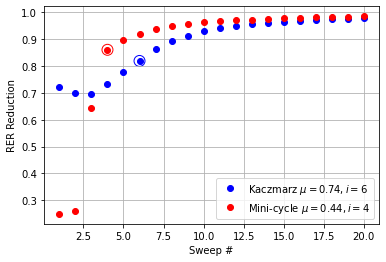

In [30]:
check_relax_cycle_shrinkage(multilevel)

Even though per work unit it is about the same (the mini-cycle is $6$ relaxations worth), the two-level relaxation cycle reduces the RER much more than Kaczmarz until the point of diminishing returns.

As expected, both methods are asymptotically slow (probably the same rate of convergence).

### Effect of a Second Bootstrap Cycle

In [31]:
x, multilevel = hm.setup.auto_setup.bootstap(
    x, multilevel, num_levels, 2.0,
    num_sweeps=num_sweeps, interpolation_method=interpolation_method, threshold=threshold)
x_log.append(x)
r_log.append(multilevel.level[1].r)
_LOGGER.info("RER {:.3f}".format(norm(a.dot(x)) / norm(x)))

INFO     Relax cycle conv factor 0.949 asymptotic RQ 0.038 RER 0.101 P error 0.021
INFO     Improving vectors by relaxation cycles
INFO     Coarsening level 0->1
WARNING  Could not find a good coarsening ratio for aggregate 95:96, n 1 nc 1 cr 1.00
INFO     Agg [4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 1]
INFO     nc  [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1]
INFO     Energy error mean 0.0239 max 0.0595
INFO     Mock cycle conv factor [0.578 0.329 0.191 0.13  0.138 0.127 0.083 0.061 0.059 0.054 0.047]
INFO     P max error: fit 0.027 val 0.020 test 0.073; alpha mean 0.001
INFO     fit  set size 15 P L2 error mean 0.00 max 0.01 A error mean 0.01 max 0.02
INFO     test set size 5  P L2 error mean 0.01 max 0.01 A error mean 0.02 max 0.03
INFO     Level 1 size 49
INFO     RER 0.078


INFO         0 |r| 1.33549600e+00 RER 2.98872
INFO         1 |r| 7.46851627e-01 (0.55983) RER 2.21334 (0.74107) 0.33768
INFO         2 |r| 4.34111899e-01 (0.58122) RER 1.51905 (0.68652) 0.28595
INFO         3 |r| 2.70957993e-01 (0.62398) RER 1.04251 (0.68619) 0.26008
INFO         4 |r| 1.82753400e-01 (0.67410) RER 0.74585 (0.71513) 0.24520
INFO         5 |r| 1.35520738e-01 (0.74169) RER 0.57586 (0.77213) 0.23554
INFO         6 |r| 1.08672804e-01 (0.80221) RER 0.47592 (0.82696) 0.22850
INFO         7 |r| 9.16517412e-02 (0.84344) RER 0.41120 (0.86437) 0.22297
INFO         8 |r| 8.00743183e-02 (0.87376) RER 0.36662 (0.89200) 0.21841
INFO         9 |r| 7.18445911e-02 (0.89714) RER 0.33482 (0.91339) 0.21453
INFO        10 |r| 6.57015863e-02 (0.91429) RER 0.31108 (0.92902) 0.21112
INFO        11 |r| 6.09131923e-02 (0.92667) RER 0.29261 (0.94020) 0.20809
INFO        12 |r| 5.70192863e-02 (0.93547) RER 0.27758 (0.94801) 0.20534
INFO        13 |r| 5.37693394e-02 (0.94231) RER 0.26503 (0.95403) 

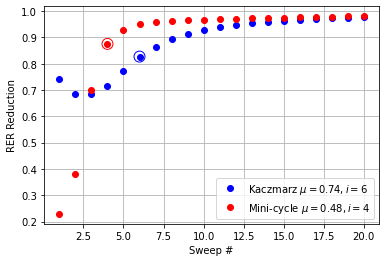

In [32]:
check_relax_cycle_shrinkage(multilevel)

Looks like the final RER obtained with a relaxation cycle after one and two bootstrap cycles is the same, so we didn't make it worse.

### Effect of Bootstrap on $R$'s Singular Values

In [33]:
# Create a final R from the most updated TVs.
x_fit, x_test = x[:, :-num_test_examples], x[:, -num_test_examples:]

# Create the coarsening operator R.
r, aggregates, nc, energy_error = hm.setup.coarsening.create_coarsening_full_domain(x_fit, threshold=threshold)
r_log.append(r)

WARNING  Could not find a good coarsening ratio for aggregate 95:96, n 1 nc 1 cr 1.00


Step  0 s [1.    0.885 0.826 0.509] Energy error [0.796 0.588 0.308 0.   ]
Step  1 s [1.    0.561 0.147 0.022] Energy error [0.502 0.128 0.019 0.   ]
Step  2 s [1.    0.562 0.087 0.004] Energy error [0.495 0.076 0.004 0.   ]
Step  3 s [1.    0.409 0.062 0.003] Energy error [0.383 0.057 0.003 0.   ]


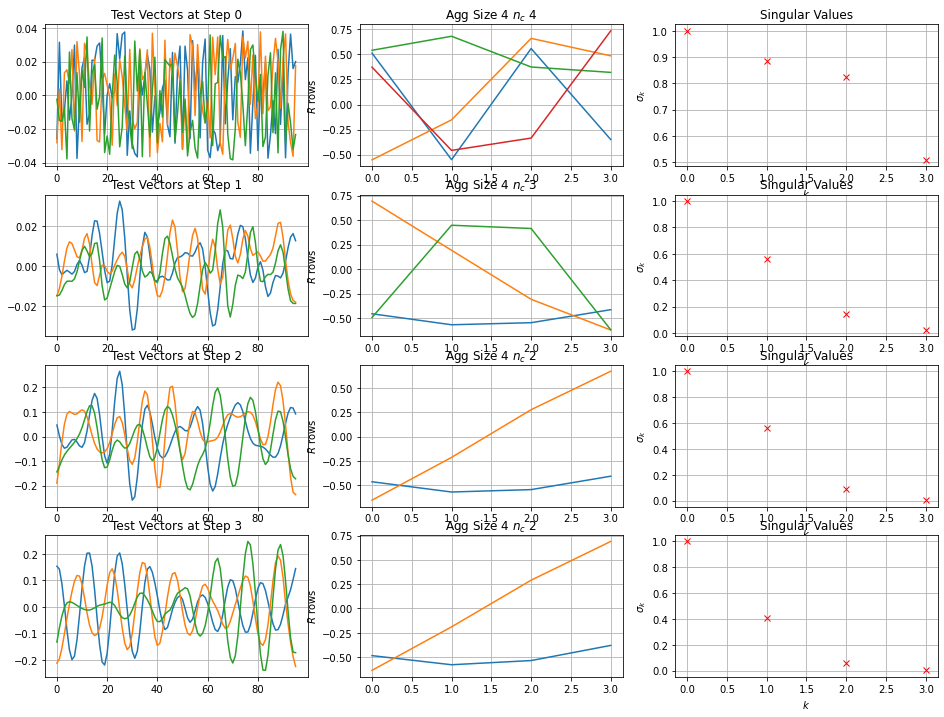

In [34]:
aggregate_size = 4
fig, axs = plt.subplots(len(x_log), 3, figsize=(16, 3 * len(x_log)))
for row, x in enumerate(x_log):
    start, end = 0, aggregate_size
    x_aggregate_t = x[start:end].transpose()
    r, s = hm.setup.coarsening.create_coarsening(x_aggregate_t, threshold)
    r = r.asarray()

    # Relaxed vectors.
    ax = axs[row, 0]
    for i in range(3):
        ax.plot(x[:, i]);
    ax.grid(True)
    ax.set_title(r"Test Vectors at Step {}".format(row))

    ax = axs[row, 1]
    # R should be real-valued, but cast just in case.
    for i, ri in enumerate(np.real(r)):
        ax.plot(ri)
    ax.set_title(r"Agg Size {} $n_c$ {}".format(r.shape[1], r.shape[0]))
    ax.set_ylabel(r"$R$ rows")
    ax.grid(True);

    # Singular values, normalized to sigma_max = 1.
    ax = axs[row, 2]
    ax.plot(s / s[0], "rx")
    ax.set_title("Singular Values")
    ax.set_xlabel(r"$k$")
    ax.set_ylabel(r"$\sigma_k$")
    ax.grid(True);
    
    print("Step {:2d}".format(row), "s", s / s[0], "Energy error", (1 - np.cumsum(s ** 2) / sum(s ** 2)) ** 0.5)

With bootstrap cycles, the smoother the TVs and the better the singular value separation: $R$ is improved.

In [35]:
# Save fine-level TVs.
x_fine = x

## Level 1->2 Coarsening
Are the equations at level 1 harder to solve than level 0 because of worse smoothing rates? Do we see a good coarsening ratio for an aggregate of size $4$ here too?

In [36]:
level = multilevel.level[1]
a = level.a
x_random = hm.solve.run.random_test_matrix((a.shape[0],), num_examples=num_examples)
b = np.zeros_like(x_random)

### Relaxation Shrinkage Factor

INFO         0 |r| 3.07922942e+00 RER 6.70964
INFO         1 |r| 4.15906765e-01 (0.24602) RER 1.27145 (0.32299) 0.34289
INFO         2 |r| 3.01493911e-01 (0.78925) RER 0.98344 (0.85457) 0.31611
INFO         3 |r| 1.92643052e-01 (0.70035) RER 0.65694 (0.73516) 0.30176
INFO         4 |r| 1.49689103e-01 (0.81250) RER 0.52481 (0.84319) 0.29106
INFO         5 |r| 1.30599979e-01 (0.87527) RER 0.46743 (0.90167) 0.28265
INFO         6 |r| 1.24195898e-01 (0.94539) RER 0.45437 (0.96905) 0.27585
INFO         7 |r| 1.20600566e-01 (0.97121) RER 0.45060 (0.99178) 0.27023
INFO         8 |r| 1.16811095e-01 (0.96805) RER 0.44464 (0.98557) 0.26552
INFO         9 |r| 1.12914724e-01 (0.96533) RER 0.43683 (0.98043) 0.26150
INFO        10 |r| 1.09054802e-01 (0.96434) RER 0.42795 (0.97752) 0.25803
INFO        11 |r| 1.05369163e-01 (0.96485) RER 0.41874 (0.97649) 0.25500
INFO        12 |r| 1.01921718e-01 (0.96616) RER 0.40965 (0.97654) 0.25233
INFO        13 |r| 9.87245907e-02 (0.96775) RER 0.40087 (0.97709) 

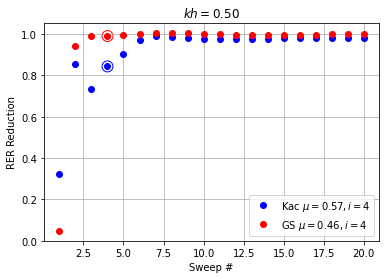

In [37]:
kaczmarz = lambda a: hm.solve.relax.KaczmarzRelaxer(a, scipy.sparse.eye(a.shape[0]))
gs = lambda a: hm.solve.relax.GsRelaxer(a)
work = 1

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

# Kaczmarz.
operator = lambda x: a.dot(x)
for title, relax, color in zip(("Kac", "GS"), (kaczmarz, gs), ("blue", "red")):
    method = relax(a)
    factor, num_sweeps, rer, conv = hm.solve.smoothing.shrinkage_factor(
        operator, lambda x, b: method.step(x, b), (a.shape[0], ), print_frequency=1, max_sweeps=20, slow_conv_factor=1.1)
    hm.solve.smoothing.plot_diminishing_returns_point(factor, num_sweeps, conv, ax, title=title, color=color)
    print("{:<10s} RER at point of diminishing returns {:.2f} num_sweeps {:>2d} work {:>2d} RER-per-sweep {:.2f}".format(
        title, np.mean(rer[num_sweeps]), num_sweeps, work, np.mean(rer[num_sweeps] / rer[0]) ** (1/(num_sweeps * work))))

ax.set_title(r"$kh = {:.2f}$".format(kh_value))
ax.legend();

Kaczmarz slows down more quickly here than on level 1. GS diverges.

### $R$ for Aggregate Size = 4

nu  5 s [1.    0.965 0.282 0.045] Energy error [0.71  0.201 0.031 0.   ]
INFO     Agg [4 4 4 1 1 4 4 4 4 4 4 4 4 1 1 1]
INFO     nc  [3 3 3 1 1 3 3 3 3 3 3 3 3 1 1 1]
INFO     Energy error mean 0.0860 max 1.0000
INFO     Mock cycle conv factor [0.16  0.024 0.026 0.01  0.008 0.005 0.004 0.005 0.004 0.003 0.003 0.003 0.003 0.003 0.002]
nu 10 s [1.    0.827 0.257 0.031] Energy error [0.655 0.196 0.023 0.   ]
INFO     Agg [4 4 4 1 1 4 4 4 4 4 4 4 4 1 1 1]
INFO     nc  [3 3 3 1 1 3 3 3 3 3 3 3 3 1 1 1]
INFO     Energy error mean 0.0788 max 1.0000
INFO     Mock cycle conv factor [0.082 0.03  0.02  0.01  0.008 0.007 0.005 0.005 0.005 0.003 0.004 0.003 0.003 0.002 0.003]
nu 20 s [1.    0.673 0.215 0.02 ] Energy error [0.577 0.177 0.016 0.   ]
INFO     Agg [4 4 4 1 1 4 4 4 4 4 4 4 4 1 1 1]
INFO     nc  [3 3 3 1 1 3 3 3 3 3 3 3 3 1 1 1]
INFO     Energy error mean 0.0718 max 1.0000
INFO     Mock cycle conv factor [0.098 0.027 0.013 0.012 0.009 0.006 0.007 0.006 0.004 0.005 0.005 0.005 0.003 0.002

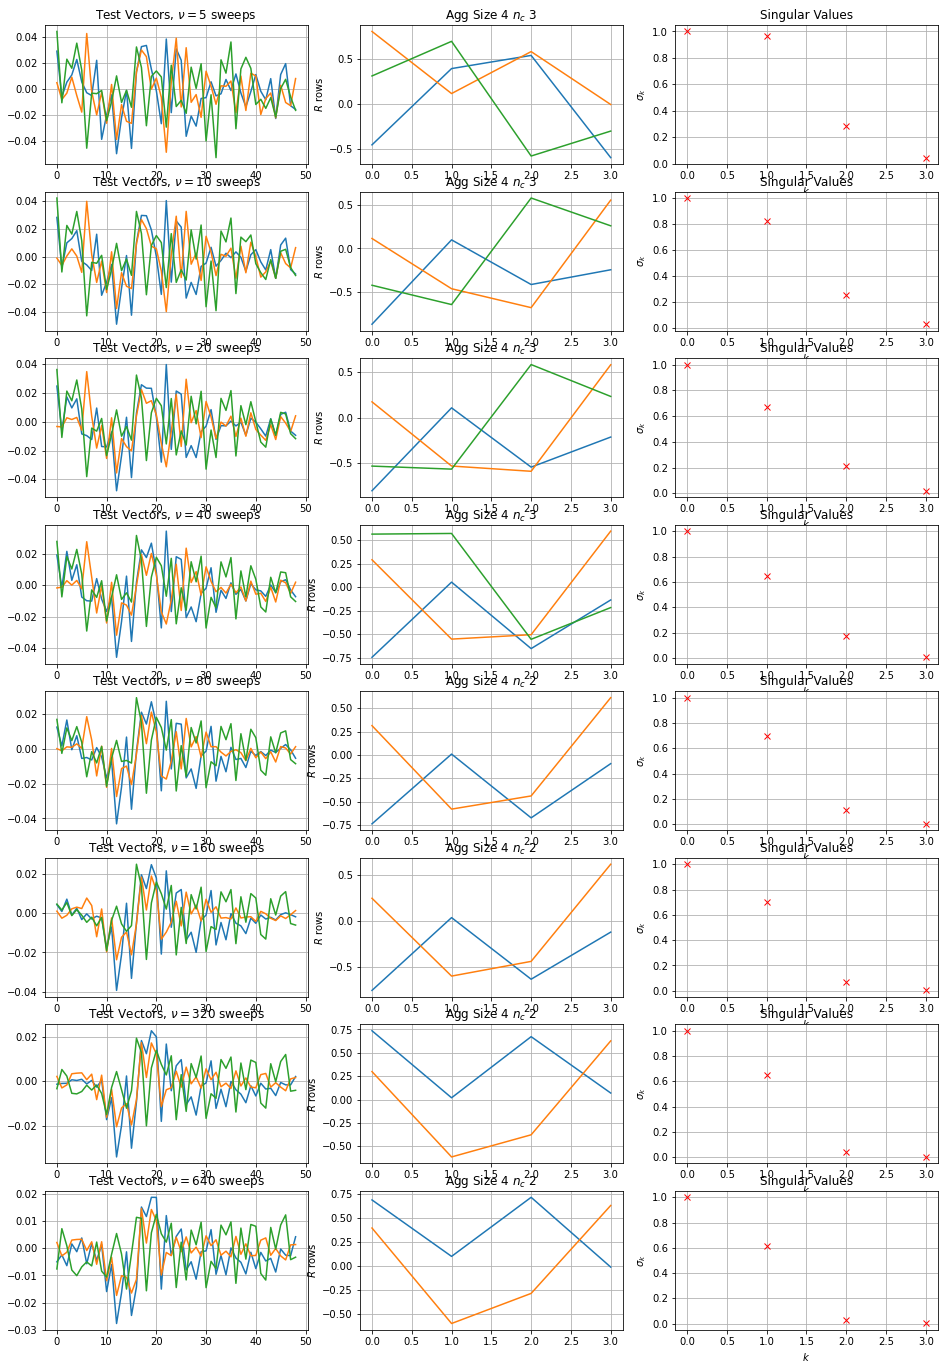

In [38]:
check_coarsening(level, 4)

It looks like it takes a lot more relaxation sweeps to see $2$ components in a size $4$ aggregate here. Mock cycle rates are also worse.

### $R$ for Aggregate Size = 6

nu  5 s [1.    0.898 0.64  0.283 0.077 0.022] Energy error [0.752 0.464 0.194 0.053 0.015 0.   ]
INFO     Agg [6 6 6 6 6 6 6 6 1]
INFO     nc  [4 5 5 4 4 4 4 4 1]
INFO     Energy error mean 0.1438 max 1.0000
INFO     Mock cycle conv factor [0.525 0.273 0.141 0.068 0.029 0.008 0.007 0.005 0.005 0.003 0.004 0.004 0.002 0.003 0.003]
nu 10 s [1.    0.759 0.464 0.276 0.051 0.007] Energy error [0.682 0.397 0.205 0.038 0.005 0.   ]
INFO     Agg [6 6 6 6 6 6 6 6 1]
INFO     nc  [4 4 5 4 4 4 4 4 1]
INFO     Energy error mean 0.1425 max 1.0000
INFO     Mock cycle conv factor [0.535 0.268 0.337 0.284 0.245 0.213 0.186 0.163 0.144 0.127 0.113 0.1   0.089 0.08  0.072]
nu 20 s [1.    0.724 0.276 0.196 0.04  0.003] Energy error [0.625 0.266 0.156 0.031 0.002 0.   ]
INFO     Agg [6 6 6 6 6 6 6 6 1]
INFO     nc  [4 4 5 4 4 4 4 3 1]
INFO     Energy error mean 0.1364 max 1.0000
INFO     Mock cycle conv factor [0.58  0.497 0.431 0.343 0.293 0.242 0.255 0.195 0.166 0.143 0.135 0.126 0.101 0.098 0.078]
nu 4

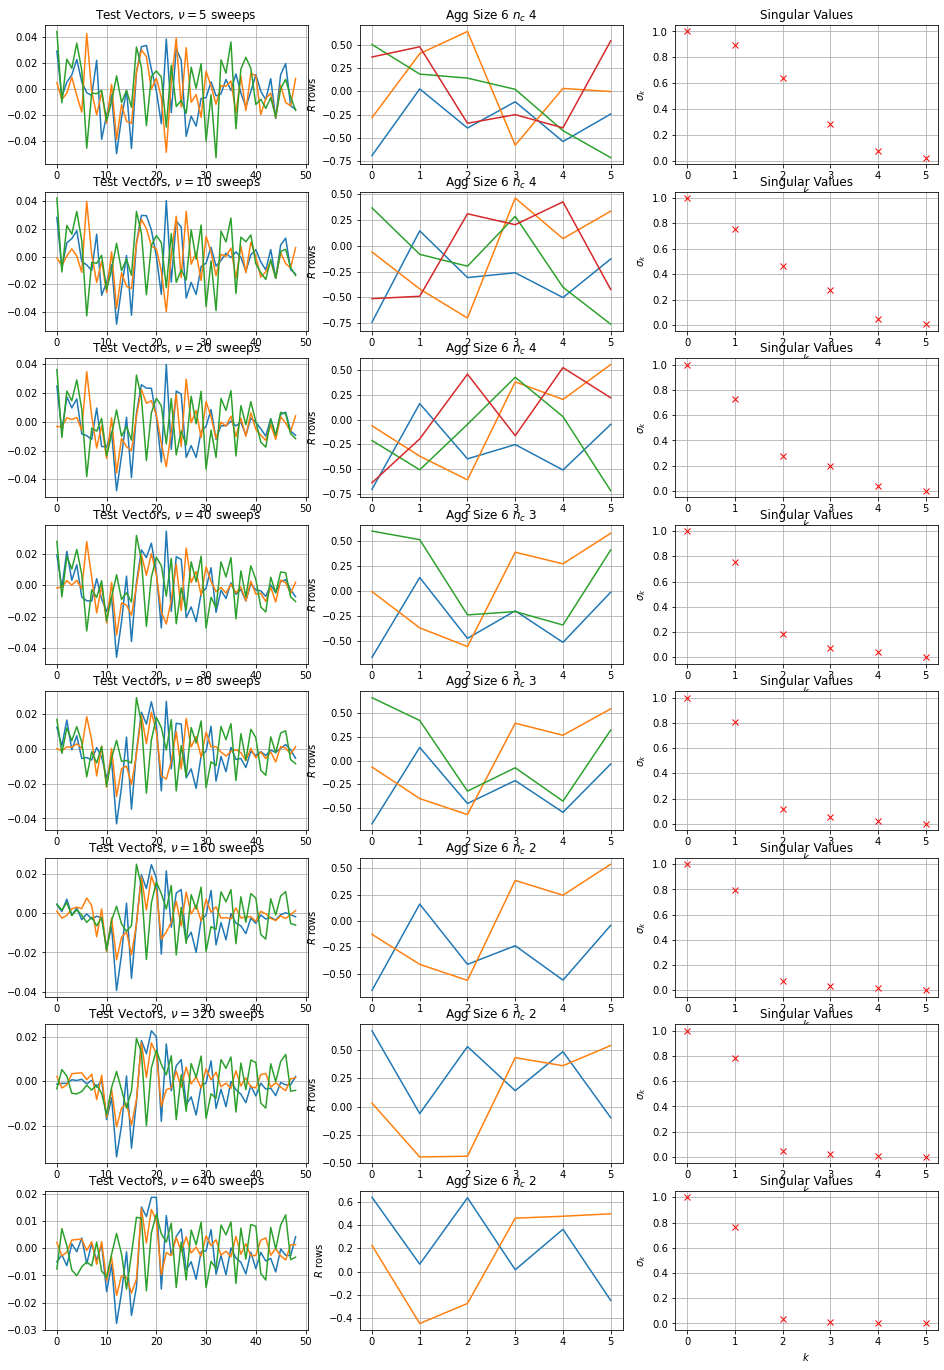

In [39]:
check_coarsening(level, 6)

One can obtain a good coarsening here too (in terms of coarsening ratio and mock cycle rates), with an aggregate size of $6$ and $3$ coarse variables. Note that this requires less smoothing ($\nu = 40$) than for an aggregate size of $4$, where we stll $3$ PCs until $\nu$ is much larger ($320$). Thus, a general criterion would find the larger aggregate size.

The mock cycle rates are worse than for level 0, but we can still obtain improvement when more relaxations per cycle are added. Convergence of $0.2$ is obtained for $11$ relaxations per cycle, as opposed to $3$ at level 0.

### $R$ with Dynamic Aggregate Size

nu  5 s [1.    0.965 0.282 0.045] Energy error [0.71  0.201 0.031 0.   ]
WARNING  Could not find a good coarsening ratio for aggregate 0:8, n 8 nc 5 cr 0.62
WARNING  Could not find a good coarsening ratio for aggregate 18:26, n 8 nc 5 cr 0.62
WARNING  Could not find a good coarsening ratio for aggregate 26:34, n 8 nc 5 cr 0.62
WARNING  Could not find a good coarsening ratio for aggregate 34:42, n 8 nc 5 cr 0.62
WARNING  Could not find a good coarsening ratio for aggregate 42:49, n 7 nc 4 cr 0.57
INFO     Agg [8 6 4 8 8 8 7]
INFO     nc  [5 4 3 5 5 5 4]
INFO     Energy error mean 0.0422 max 0.0955
INFO     Mock cycle conv factor [0.559 0.303 0.162 0.088 0.094 0.071 0.054 0.041 0.032 0.014 0.02  0.013 0.015 0.01  0.008]
nu 10 s [1.    0.827 0.257 0.031] Energy error [0.655 0.196 0.023 0.   ]
WARNING  Could not find a good coarsening ratio for aggregate 0:8, n 8 nc 5 cr 0.62
WARNING  Could not find a good coarsening ratio for aggregate 18:26, n 8 nc 5 cr 0.62
WARNING  Could not find a goo

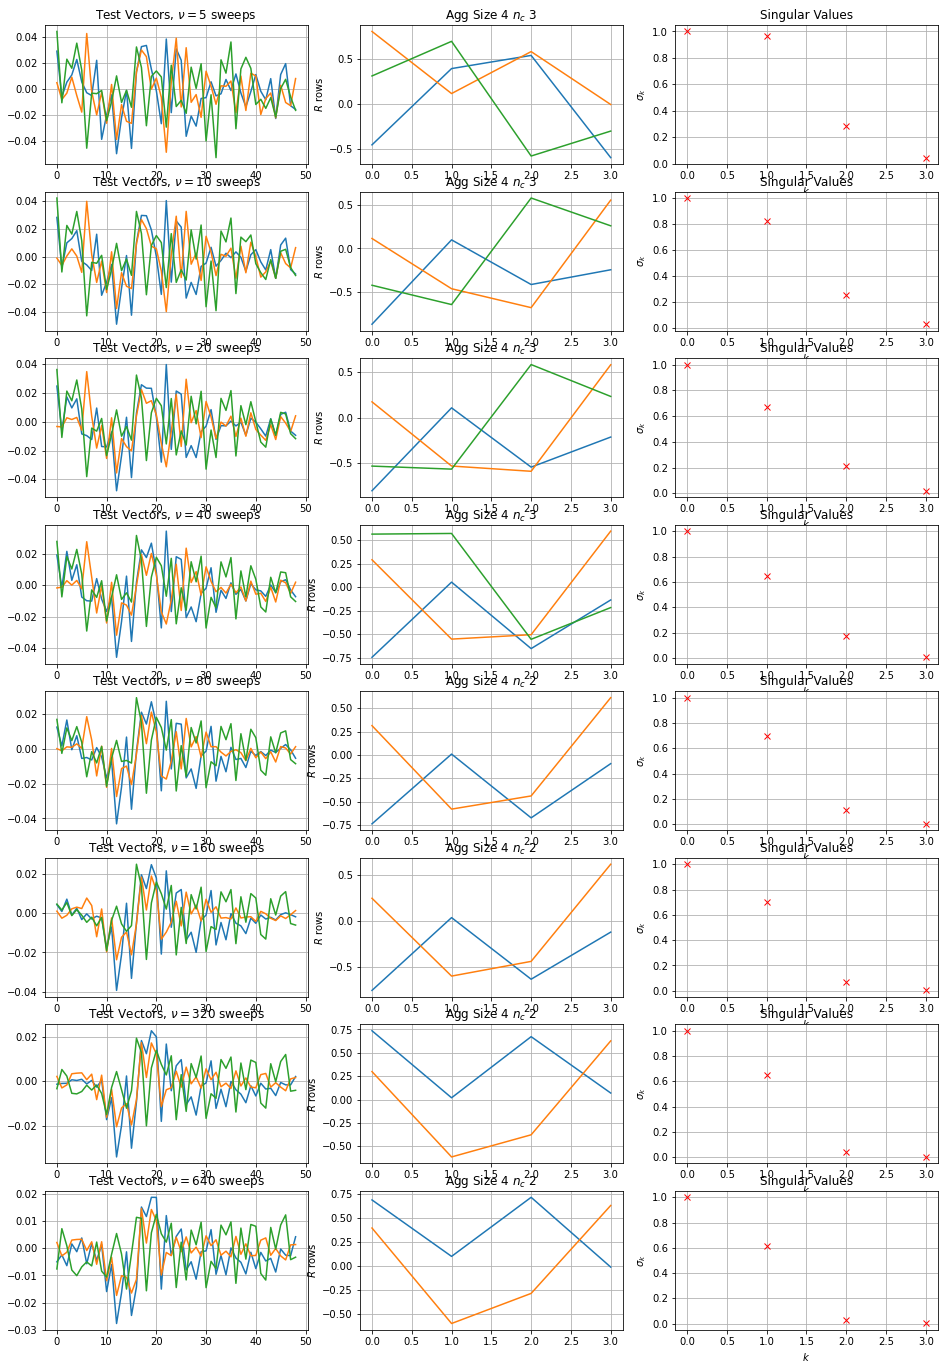

In [40]:
check_coarsening(level, None)

### Two-level Bootstrapping

In [41]:
max_levels = 2
num_bootstrap_steps = 3
num_sweeps = 20

x_log = []
r_log = []

# Initialize hierarchy to 1-level and fine-level test functions to random.
finest = 0
multilevel = hm.hierarchy.multilevel.Multilevel(level)

_LOGGER.info("Relax at level {} size {}".format(finest, level.size))
b = np.zeros((a.shape[0], num_examples))
_, relax_conv_factor = hm.solve.run.run_iterative_method(
    level.operator, lambda x: level.relax(x, b), 
    hm.solve.run.random_test_matrix((a.shape[0],), num_examples=num_examples), num_sweeps=100)
_LOGGER.info("Relax convergence factor {:.3f}".format(relax_conv_factor))

# Restrict test vectors from next-finer levels instead of starting from random.
x = level.coarsen(x_fine)
x_log.append(x)

# Improve vectors with 1-level relaxation.
_LOGGER.info("Generating TVs with {} sweeps".format(num_sweeps))
x, _ = hm.solve.run.run_iterative_method(
    level.operator, lambda x: level.relax(x, b), x, num_sweeps=num_sweeps)
_LOGGER.info("RER {:.3f}".format(norm(a.dot(x)) / norm(x)))
x_log.append(x)

# Bootstrap with an increasingly deeper hierarchy (add one level at a time).
num_levels = 2
_LOGGER.info("bootstrap on grid size {} with {} levels".format(x.shape[0], max_levels))
_LOGGER.info("-" * 80)
for i in range(num_bootstrap_steps):
    _LOGGER.info("Bootstrap step {}/{}".format(i + 1, num_bootstrap_steps))
    # Set relax_conv_factor to a high value so that we never append a bootstrap vector to the TV set.
    x, multilevel = hm.setup.auto_setup.bootstap(
        x, multilevel, num_levels, 2.0,
        num_sweeps=num_sweeps, interpolation_method=interpolation_method, threshold=threshold)
    x_log.append(x)
    r_log.append(multilevel.level[1].r)
    _LOGGER.info("RER {:.6f}".format(norm(a.dot(x)) / norm(x)))
    _LOGGER.info("-" * 80)

INFO     Relax at level 0 size 49
INFO     Relax convergence factor 0.997
INFO     Generating TVs with 20 sweeps
INFO     RER 0.081
INFO     bootstrap on grid size 49 with 2 levels
INFO     --------------------------------------------------------------------------------
INFO     Bootstrap step 1/3
INFO     Relax cycle conv factor 0.999 asymptotic RQ -0.016 RER 0.145 P error -1.000
INFO     Improving vectors by relaxation cycles
INFO     Coarsening level 0->1
WARNING  Could not find a good coarsening ratio for aggregate 48:49, n 1 nc 1 cr 1.00
INFO     Agg [4 4 6 4 8 4 4 4 4 4 1 1 1]
INFO     nc  [2 2 3 2 4 2 2 2 2 2 1 1 1]
INFO     Energy error mean 0.0446 max 0.0995
INFO     Mock cycle conv factor [0.915 0.958 0.946 0.923 0.913 0.889 0.88  0.858 0.757 0.845 0.81 ]
INFO     P max error: fit 0.029 val 0.106 test 0.022; alpha mean 0.000
INFO     fit  set size 15 P L2 error mean 0.01 max 0.01 A error mean 0.05 max 0.12
INFO     test set size 5  P L2 error mean 0.01 max 0.01 A error mean 0

In [42]:
# Create a final R from the most updated TVs.
x_fit, x_test = x[:, :-num_test_examples], x[:, -num_test_examples:]

# Create the coarsening operator R.
r, aggregates, nc, energy_error = hm.setup.coarsening.create_coarsening_full_domain(x_fit, threshold=threshold)
r_log.append(r)

WARNING  Could not find a good coarsening ratio for aggregate 48:49, n 1 nc 1 cr 1.00


Step  0 s [1.    0.629 0.193 0.012] Energy error [0.55  0.161 0.01  0.   ]
Step  1 s [1.    0.626 0.123 0.003] Energy error [0.538 0.104 0.003 0.   ]
Step  2 s [1.    0.658 0.069 0.003] Energy error [0.552 0.057 0.003 0.   ]
Step  3 s [1.    0.884 0.146 0.001] Energy error [0.667 0.108 0.001 0.   ]
Step  4 s [1.    0.532 0.052 0.001] Energy error [0.471 0.046 0.001 0.   ]


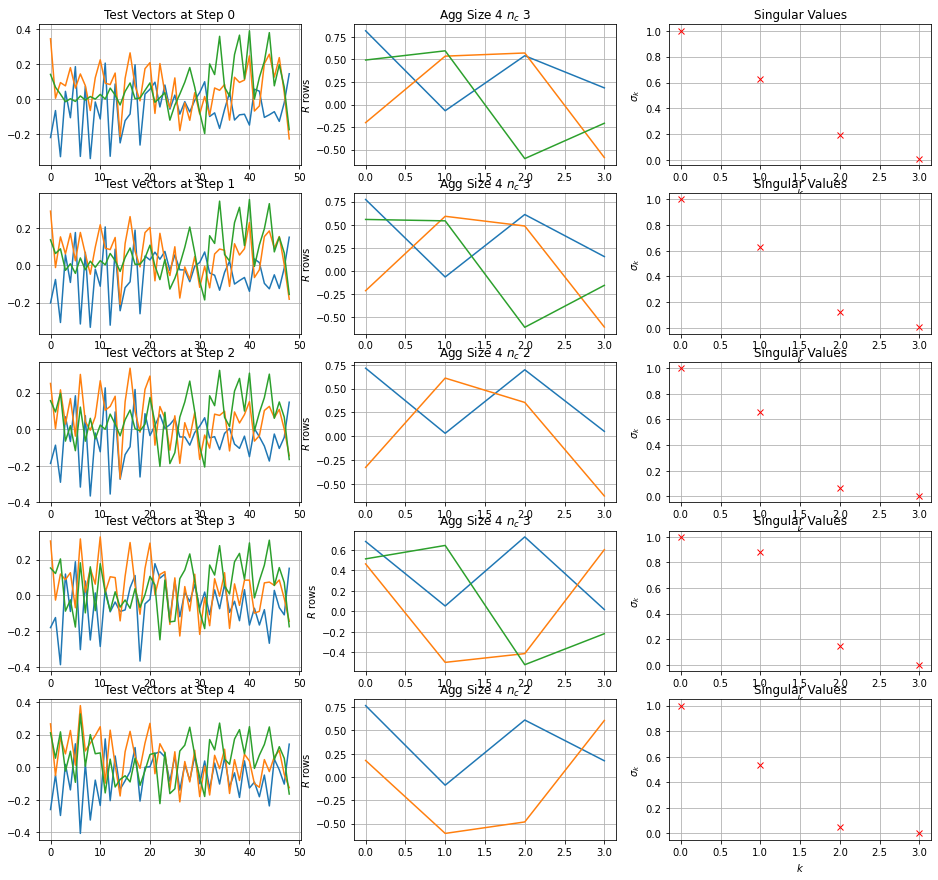

In [43]:
aggregate_size = 4
fig, axs = plt.subplots(len(x_log), 3, figsize=(16, 3 * len(x_log)))
for row, x in enumerate(x_log):
    start, end = 0, aggregate_size
    x_aggregate_t = x[start:end].transpose()
    r, s = hm.setup.coarsening.create_coarsening(x_aggregate_t, threshold)
    r = r.asarray()

    # Relaxed vectors.
    ax = axs[row, 0]
    for i in range(3):
        ax.plot(x[:, i]);
    ax.grid(True)
    ax.set_title(r"Test Vectors at Step {}".format(row))

    ax = axs[row, 1]
    # R should be real-valued, but cast just in case.
    for i, ri in enumerate(np.real(r)):
        ax.plot(ri)
    ax.set_title(r"Agg Size {} $n_c$ {}".format(r.shape[1], r.shape[0]))
    ax.set_ylabel(r"$R$ rows")
    ax.grid(True);

    # Singular values, normalized to sigma_max = 1.
    ax = axs[row, 2]
    ax.plot(s / s[0], "rx")
    ax.set_title("Singular Values")
    ax.set_xlabel(r"$k$")
    ax.set_ylabel(r"$\sigma_k$")
    ax.grid(True);
    
    print("Step {:2d}".format(row), "s", s / s[0], "Energy error", (1 - np.cumsum(s ** 2) / sum(s ** 2)) ** 0.5)

Here we also observe that the singular value gap increases with bootsrap cycles, but no longer monotonically (it is noisy).

INFO         0 |r| 3.13545284e+00 RER 6.93348
INFO         1 |r| 4.36989235e-01 (0.16345) RER 1.33576 (0.22037) 0.33085
INFO         2 |r| 3.12313651e-01 (0.70710) RER 1.05808 (0.78810) 0.29801
INFO         3 |r| 1.56176379e-01 (0.52559) RER 0.54529 (0.54982) 0.28502
INFO         4 |r| 1.14118451e-01 (0.74394) RER 0.41230 (0.77326) 0.27472
INFO         5 |r| 9.86699854e-02 (0.86734) RER 0.36414 (0.89405) 0.26674
INFO         6 |r| 9.39268519e-02 (0.95301) RER 0.35509 (0.97798) 0.26018
INFO         7 |r| 9.03846735e-02 (0.96199) RER 0.34890 (0.98349) 0.25471
INFO         8 |r| 8.70921961e-02 (0.96155) RER 0.34205 (0.98010) 0.25009
INFO         9 |r| 8.37437129e-02 (0.95802) RER 0.33358 (0.97418) 0.24612
INFO        10 |r| 8.05332027e-02 (0.95681) RER 0.32453 (0.97109) 0.24266
INFO        11 |r| 7.76130858e-02 (0.95806) RER 0.31581 (0.97084) 0.23962
INFO        12 |r| 7.50330174e-02 (0.96074) RER 0.30789 (0.97229) 0.23692
INFO        13 |r| 7.27798854e-02 (0.96398) RER 0.30087 (0.97449) 

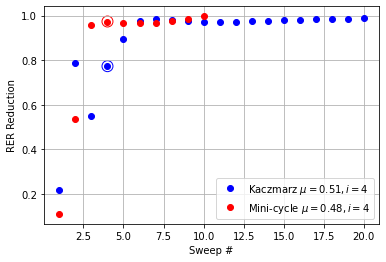

In [44]:
check_relax_cycle_shrinkage(multilevel)

## Questions
* How can we see from the shrinkage factor runs that Kaczmarz is a less effective shrinker (candidate smoother) at level 1 than level 0?
* Why is two-level mini-cycle on level 1 not working, i.e., it yields the same RER as relaxation after the initial convergence, even though the $P$ errors in the energy norm are small?
* Why aren't level 1 TVs getting smoother with bootstrap cycles? Their RER oscillates ($0.08-0.13$). The initial vectors on this level (coarsening of the level 0 TVs) already have RER = $0.08$.